# Conclusion
Our method is robust to the choice of $\eta$.
But the ideal choice of $\eta\in\{0.01, 0.001,0.0001,0.0\}$

## 

In [1]:
import pandas as pd
import os
import json
import numpy as np


def collect_data_p(p: str, datasets=[], result_dir='results', train_test_flag="test"):
    """
    Collects data from multiple datasets and methods for a specific missingness percentage,
    and formats it into a DataFrame.
    
    Args:
        p (str): The missingness percentage (e.g., "0.0").
        datasets (list): List of dataset names to analyze.
        output_dir (str): The base directory where results are saved.
        
    Returns:
        pd.DataFrame: A DataFrame containing formatted results for each method and imputation.
    """
    if not datasets:
        datasets = [d for d in os.listdir(result_dir) if os.path.isdir(os.path.join(result_dir, d))]
    
    for dataset in datasets[1:]:
        dataset_dir = os.path.join(result_dir, dataset)
        method_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
        break
    # print(method_dirs)
    method_dirs = [e for e in method_dirs if 'Balu' in e] # or 'gnn' in e or '9' in e or '10' in e]
    print("methods:", method_dirs)

    def fileter_method(must_item: list, method):
        method_name = method
        for item in must_item:
            if item not in method:
                return False, None
            if "L=" in item or 'Balu_plus' in item:
                item = item 
            else:
                item = "_"+item if "_" not in item else item
            method_name = method_name.replace(item, "")
        return True, method_name

    def safe_float_convert(value):
        if value is None:
            return np.nan
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    # 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001'

    data_rows = []
    raw_data_rows = []
    for method in method_dirs:
        # flag, method_name = fileter_method(['Balu_plus_imp=', 'L=64-64_K=64', "gconv=GCN_rconv=GCN", "reldrop=0.0", "gamma=0.0001_eta=0.0001"], method)
        flag, method_name = fileter_method(['Balu_plus_imp=', 'L=64-64_K=64', "gconv=GCN_rconv=GCN", "reldrop=0.0_beta=0.0001", "gamma=0.0001"], method)
        if not flag:
            continue
        if "-64" in method_name or "BaLu" not in method_name:
            continue
        
        row = {
            'method': method_name,
            # 'imputation': imputation
        }
        
        # Collect results for each dataset
        for dataset in datasets:
            dataset_dir = os.path.join(result_dir, dataset)
            if not os.path.exists(dataset_dir):
                print(f"{dataset_dir} not exits!")
                # Dataset doesn't exist, fill with N/A
                row[f"{dataset}_PEHE"] = "N/A"
                row[f"{dataset}_MAE"] = "N/A"
                continue
                
            method_dir = os.path.join(dataset_dir, method)
            if not os.path.exists(method_dir):
                # Method doesn't exist for this dataset, fill with N/A
                row[f"{dataset}_PEHE"] = "N/A"
                row[f"{dataset}_MAE"] = "N/A"
                continue
            
            imputation_dir = method_dir
            
            results_files = [f for f in os.listdir(imputation_dir) 
                        if f.startswith(f"p={p}_") and f.endswith(f"_{train_test_flag}_results.json")]
            if "complete" not in train_test_flag:
                results_files = [f for f in results_files if "complete" not in f]
            # results_files=results_files[:len(results_files)*1.5//2]

            # print(results_files)
            effect_pehe_values = []
            effect_mae_values = []
            effect_sum_values = []
            
            # print(results_files)
            for file in results_files:
                file_path = os.path.join(method_dir, file) # imputation, file)
                try:
                    with open(file_path, 'r') as f:
                        results = json.load(f)
                        pehe_val = safe_float_convert(results.get('effect_pehe'))
                        mae_val = safe_float_convert(results.get('effect_mae'))
                        
                        # Check for problematic values
                        if np.isnan(pehe_val) or np.isnan(mae_val):
                            print(f"NaN detected in: {file_path}")
                            print(f"  PEHE: {results.get('effect_pehe')} -> {pehe_val}")
                            print(f"  MAE: {results.get('effect_mae')} -> {mae_val}")
                            continue  # Skip this file entirely
                        
                        # Only add valid values
                        effect_pehe_values.append(pehe_val)
                        effect_mae_values.append(mae_val)
                        sum_val = pehe_val + mae_val
                        effect_sum_values.append(sum_val)
                        
                        raw_data_rows.append({
                            'method': method_name,
                            'Dataset': dataset,
                            f'PEHE': pehe_val,
                            f"MAE": mae_val,
                            f"SUM": sum_val
                        })

                except (json.JSONDecodeError, FileNotFoundError) as e:
                    print(f"Warning: Error reading file {file_path}: {e}")
            
            if effect_pehe_values:
                mean_pehe = np.mean(effect_pehe_values)
                std_pehe = np.std(effect_pehe_values)
                row[f"{dataset}_PEHE"] = f"{mean_pehe:.2f} ± {std_pehe:.2f}"
            else:
                row[f"{dataset}_PEHE"] = "N/A"
            
            if effect_mae_values:
                mean_mae = np.mean(effect_mae_values)
                std_mae = np.std(effect_mae_values)
                row[f"{dataset}_MAE"] = f"{mean_mae:.2f} ± {std_mae:.2f}"
            else:
                row[f"{dataset}_MAE"] = "N/A"

            if effect_sum_values:
                mean_sum = np.mean(effect_sum_values)
                std_sum = np.std(effect_sum_values)
                row[f"{dataset}_SUM"] = f"{mean_sum:.2f} ± {std_sum:.2f}"
            else:
                row[f"{dataset}_SUM"] = 'N/A'
        data_rows.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    df_raw = pd.DataFrame(raw_data_rows)
    
    
    # Sort the DataFrame by method and imputation
    if not df.empty:
        df = df.sort_values(by=['method']) #, 'imputation'])
        df_raw = df_raw.sort_values(by=['method'])
    return df, df_raw

def display_results(result_dir, p, datasets=["Syn"], train_test_flag='test', metrics=['SUM']):
    

    # Set display options to show all rows and columns
    pd.set_option('display.max_rows', None)  # Show all rows
    pd.set_option('display.max_columns', None)  # Show all columns
    pd.set_option('display.width', None)  # Use the full width of the notebook cell
    pd.set_option('display.max_colwidth', None)  # Show full content of each column

    # Example: Display the DataFrame created by collect_data_p
    df, _ = collect_data_p(p, datasets=datasets, result_dir=result_dir, train_test_flag=train_test_flag) 
    dataset_map = {'Syn_M=None_SimRel=1_Rel=4':"Instagram",  'BlogCatalog1_M=20_SimRel=0_Rel=1':"BlogCatalog", 'BlogCatalog1_M=20_SimRel=1_Rel=4':"BlogCatalog", 'Flickr1_M=20_SimRel=0_Rel=1':"Flickr", 'Flickr1_M=20_SimRel=1_Rel=4':"Flickr", 'Youtube_M=20_SimRel=1_Rel=4':"Youtube"}
    
    def replace_col(col):
        for k, v in dataset_map.items():
            if k in col:

                return col.replace(k, v).replace("_MCAR","")
        return col

    new_column_names = [replace_col(col) for col in df.columns]
    df.columns = new_column_names
    display(df)
    # print(df.to_latex(index=False, escape=False))
    # print(df.to_markdown(index=False))

# display_results(p='0.5', train_test_flag='test')

In [2]:
datasets = ['Syn_M=None_SimRel=1_Rel=4', 'Youtube_M=20_SimRel=1_Rel=4', 'BlogCatalog1_M=20_SimRel=0_Rel=1', 'Flickr1_M=20_SimRel=0_Rel=1']     # , 'BlogCatalog1_M=20_SimRel=1_Rel=4', 'Flickr1_M=20_SimRel=1_Rel=4'
datasets = [e+"_MCAR" for e in datasets] 
result_dir = 'results_balu_tuning'

display_results(result_dir=result_dir, p='0.0', datasets=datasets, train_test_flag='test')
display_results(result_dir=result_dir, p='0.1', datasets=datasets, train_test_flag='test')
display_results(result_dir=result_dir, p='0.3', datasets=datasets, train_test_flag='test')
# display_results(result_dir='results_Q1', p='0.5', datasets=datasets, train_test_flag='test')


methods: ['Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GraphSAGE_rconv=RGCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GAT_rconv=GAT_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.01_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.1_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.1_eta=0.0001', 'Balu_plus_imp=BaLu_IGM

,method,Instagram_PEHE,Instagram_MAE,Instagram_SUM,Youtube_PEHE,Youtube_MAE,Youtube_SUM,BlogCatalog_PEHE,BlogCatalog_MAE,BlogCatalog_SUM,Flickr_PEHE,Flickr_MAE,Flickr_SUM
6,BaLu_GRAPE___eta=0.0,0.80 ± 0.03,0.06 ± 0.04,0.86 ± 0.04,0.79 ± 0.02,0.03 ± 0.03,0.82 ± 0.04,7.35 ± 3.91,0.93 ± 0.46,8.28 ± 4.24,7.19 ± 1.70,0.99 ± 0.46,8.18 ± 1.93
5,BaLu_GRAPE___eta=0.0001,0.80 ± 0.03,0.05 ± 0.04,0.86 ± 0.04,0.79 ± 0.02,0.03 ± 0.03,0.83 ± 0.04,7.30 ± 3.72,0.93 ± 0.47,8.23 ± 4.06,7.25 ± 1.73,1.03 ± 0.46,8.29 ± 1.93
8,BaLu_GRAPE___eta=0.001,0.80 ± 0.03,0.05 ± 0.04,0.86 ± 0.04,0.79 ± 0.02,0.03 ± 0.02,0.82 ± 0.03,7.25 ± 3.89,0.79 ± 0.39,8.05 ± 4.20,7.08 ± 1.81,0.99 ± 0.37,8.07 ± 1.96
0,BaLu_GRAPE___eta=0.01,0.80 ± 0.03,0.05 ± 0.04,0.85 ± 0.05,0.79 ± 0.02,0.04 ± 0.02,0.83 ± 0.04,7.37 ± 4.19,0.85 ± 0.48,8.22 ± 4.49,7.17 ± 1.82,1.17 ± 0.34,8.34 ± 1.96
9,BaLu_GRAPE___eta=0.1,0.79 ± 0.03,0.04 ± 0.03,0.84 ± 0.03,0.79 ± 0.03,0.04 ± 0.02,0.83 ± 0.03,7.42 ± 4.01,0.89 ± 0.58,8.31 ± 4.35,7.07 ± 1.76,1.07 ± 0.18,8.14 ± 1.76
1,BaLu_IGMC___eta=0.0,0.80 ± 0.02,0.06 ± 0.03,0.86 ± 0.04,0.79 ± 0.02,0.02 ± 0.02,0.81 ± 0.04,7.40 ± 3.89,0.96 ± 0.75,8.36 ± 4.33,7.41 ± 1.70,1.09 ± 0.39,8.51 ± 1.73
4,BaLu_IGMC___eta=0.0001,0.80 ± 0.02,0.06 ± 0.03,0.86 ± 0.04,0.79 ± 0.02,0.03 ± 0.02,0.82 ± 0.04,7.45 ± 3.96,0.90 ± 0.61,8.35 ± 4.31,7.44 ± 1.76,1.09 ± 0.38,8.53 ± 1.77
3,BaLu_IGMC___eta=0.001,0.80 ± 0.02,0.06 ± 0.03,0.86 ± 0.04,0.79 ± 0.02,0.03 ± 0.02,0.82 ± 0.04,7.40 ± 3.92,0.90 ± 0.83,8.31 ± 4.57,7.38 ± 1.59,1.01 ± 0.38,8.39 ± 1.71
7,BaLu_IGMC___eta=0.01,0.80 ± 0.02,0.06 ± 0.03,0.86 ± 0.04,0.79 ± 0.02,0.02 ± 0.02,0.81 ± 0.04,7.47 ± 4.11,0.89 ± 0.63,8.36 ± 4.48,7.44 ± 1.69,1.11 ± 0.39,8.55 ± 1.71
2,BaLu_IGMC___eta=0.1,0.79 ± 0.02,0.05 ± 0.02,0.84 ± 0.04,0.78 ± 0.02,0.03 ± 0.02,0.81 ± 0.02,7.41 ± 4.00,0.80 ± 0.58,8.21 ± 4.44,7.68 ± 1.68,1.21 ± 0.75,8.89 ± 1.76


methods: ['Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GraphSAGE_rconv=RGCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GAT_rconv=GAT_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.01_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.1_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.1_eta=0.0001', 'Balu_plus_imp=BaLu_IGM

,method,Instagram_PEHE,Instagram_MAE,Instagram_SUM,Youtube_PEHE,Youtube_MAE,Youtube_SUM,BlogCatalog_PEHE,BlogCatalog_MAE,BlogCatalog_SUM,Flickr_PEHE,Flickr_MAE,Flickr_SUM
6,BaLu_GRAPE___eta=0.0,1.88 ± 0.23,0.31 ± 0.19,2.18 ± 0.29,1.91 ± 0.20,0.12 ± 0.06,2.03 ± 0.20,7.68 ± 4.23,0.93 ± 0.58,8.62 ± 4.55,7.78 ± 2.61,0.55 ± 0.41,8.33 ± 2.90
5,BaLu_GRAPE___eta=0.0001,1.88 ± 0.23,0.31 ± 0.19,2.19 ± 0.29,1.91 ± 0.20,0.12 ± 0.06,2.03 ± 0.20,7.64 ± 4.26,0.92 ± 0.52,8.56 ± 4.54,7.94 ± 2.85,0.59 ± 0.38,8.53 ± 3.12
8,BaLu_GRAPE___eta=0.001,1.87 ± 0.22,0.31 ± 0.18,2.18 ± 0.29,1.91 ± 0.20,0.12 ± 0.06,2.03 ± 0.20,7.53 ± 4.26,0.87 ± 0.56,8.40 ± 4.55,8.01 ± 2.74,0.54 ± 0.29,8.55 ± 2.95
0,BaLu_GRAPE___eta=0.01,1.89 ± 0.25,0.31 ± 0.18,2.20 ± 0.29,1.93 ± 0.19,0.12 ± 0.06,2.05 ± 0.20,7.83 ± 4.39,0.78 ± 0.49,8.61 ± 4.72,7.82 ± 2.53,0.74 ± 0.35,8.56 ± 2.72
9,BaLu_GRAPE___eta=0.1,1.98 ± 0.28,0.36 ± 0.18,2.35 ± 0.32,2.19 ± 0.25,0.13 ± 0.07,2.32 ± 0.22,7.39 ± 3.99,0.67 ± 0.51,8.06 ± 4.03,7.43 ± 2.38,0.84 ± 0.49,8.27 ± 2.65
1,BaLu_IGMC___eta=0.0,1.84 ± 0.19,0.28 ± 0.20,2.13 ± 0.28,1.91 ± 0.21,0.11 ± 0.08,2.01 ± 0.21,8.19 ± 4.41,0.61 ± 0.34,8.80 ± 4.24,7.60 ± 1.42,0.81 ± 0.58,8.41 ± 1.71
4,BaLu_IGMC___eta=0.0001,1.85 ± 0.20,0.29 ± 0.19,2.14 ± 0.27,1.91 ± 0.21,0.10 ± 0.08,2.01 ± 0.21,8.16 ± 4.28,0.62 ± 0.33,8.78 ± 4.11,8.00 ± 1.79,0.87 ± 0.82,8.88 ± 2.38
3,BaLu_IGMC___eta=0.001,1.85 ± 0.20,0.30 ± 0.20,2.14 ± 0.28,1.91 ± 0.21,0.11 ± 0.08,2.01 ± 0.21,8.15 ± 4.20,0.48 ± 0.29,8.63 ± 4.20,7.77 ± 1.71,0.83 ± 0.55,8.60 ± 2.13
7,BaLu_IGMC___eta=0.01,1.85 ± 0.20,0.30 ± 0.20,2.16 ± 0.28,1.93 ± 0.21,0.11 ± 0.08,2.03 ± 0.21,8.34 ± 4.25,0.65 ± 0.25,8.99 ± 4.27,7.07 ± 0.85,0.51 ± 0.44,7.57 ± 0.93
2,BaLu_IGMC___eta=0.1,1.98 ± 0.28,0.35 ± 0.18,2.33 ± 0.33,2.19 ± 0.28,0.13 ± 0.08,2.32 ± 0.26,7.89 ± 4.26,0.66 ± 0.39,8.54 ± 4.33,7.15 ± 1.18,0.67 ± 0.46,7.83 ± 1.50


methods: ['Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GraphSAGE_rconv=RGCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GAT_rconv=GAT_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.01_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.1_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.1_eta=0.0001', 'Balu_plus_imp=BaLu_IGM

,method,Instagram_PEHE,Instagram_MAE,Instagram_SUM,Youtube_PEHE,Youtube_MAE,Youtube_SUM,BlogCatalog_PEHE,BlogCatalog_MAE,BlogCatalog_SUM,Flickr_PEHE,Flickr_MAE,Flickr_SUM
6,BaLu_GRAPE___eta=0.0,3.14 ± 0.61,1.08 ± 0.79,4.23 ± 1.30,3.13 ± 0.36,0.24 ± 0.13,3.36 ± 0.42,7.67 ± 3.92,1.21 ± 0.53,8.89 ± 4.14,7.32 ± 0.97,0.59 ± 0.29,7.91 ± 0.98
5,BaLu_GRAPE___eta=0.0001,3.14 ± 0.60,1.09 ± 0.78,4.23 ± 1.28,3.13 ± 0.36,0.23 ± 0.13,3.36 ± 0.42,7.65 ± 3.93,1.23 ± 0.50,8.88 ± 4.13,7.33 ± 0.96,0.51 ± 0.34,7.84 ± 1.00
8,BaLu_GRAPE___eta=0.001,3.15 ± 0.60,1.11 ± 0.77,4.26 ± 1.26,3.13 ± 0.37,0.22 ± 0.13,3.35 ± 0.43,7.77 ± 4.14,1.40 ± 0.41,9.17 ± 4.40,7.32 ± 1.06,0.52 ± 0.27,7.84 ± 1.08
0,BaLu_GRAPE___eta=0.01,3.15 ± 0.62,1.10 ± 0.80,4.25 ± 1.33,3.15 ± 0.37,0.24 ± 0.17,3.39 ± 0.47,8.63 ± 4.37,1.26 ± 0.54,9.89 ± 4.54,7.60 ± 1.13,0.56 ± 0.38,8.17 ± 1.24
9,BaLu_GRAPE___eta=0.1,3.32 ± 0.62,1.15 ± 0.80,4.47 ± 1.33,3.35 ± 0.43,0.22 ± 0.19,3.57 ± 0.57,8.55 ± 4.40,1.19 ± 0.57,9.74 ± 4.69,7.65 ± 1.72,0.57 ± 0.41,8.22 ± 1.76
1,BaLu_IGMC___eta=0.0,3.10 ± 0.60,1.09 ± 0.79,4.19 ± 1.30,3.12 ± 0.34,0.21 ± 0.18,3.33 ± 0.45,9.45 ± 5.73,1.62 ± 0.77,11.06 ± 6.01,7.48 ± 1.14,0.75 ± 0.54,8.23 ± 1.45
4,BaLu_IGMC___eta=0.0001,3.10 ± 0.60,1.08 ± 0.81,4.18 ± 1.32,3.12 ± 0.34,0.22 ± 0.17,3.34 ± 0.44,9.44 ± 5.64,1.65 ± 0.79,11.09 ± 5.90,7.46 ± 1.14,0.73 ± 0.55,8.19 ± 1.47
3,BaLu_IGMC___eta=0.001,3.09 ± 0.61,1.03 ± 0.76,4.12 ± 1.27,3.12 ± 0.34,0.22 ± 0.17,3.34 ± 0.44,9.34 ± 5.59,1.60 ± 0.82,10.94 ± 5.80,7.46 ± 1.14,0.74 ± 0.57,8.20 ± 1.48
7,BaLu_IGMC___eta=0.01,3.11 ± 0.60,1.06 ± 0.78,4.17 ± 1.28,3.13 ± 0.34,0.22 ± 0.17,3.35 ± 0.43,9.87 ± 6.76,1.78 ± 0.73,11.65 ± 7.33,7.70 ± 1.21,0.84 ± 0.52,8.53 ± 1.57
2,BaLu_IGMC___eta=0.1,3.28 ± 0.61,1.11 ± 0.84,4.39 ± 1.34,3.37 ± 0.44,0.25 ± 0.22,3.61 ± 0.59,10.00 ± 7.39,1.57 ± 0.83,11.57 ± 7.97,7.81 ± 1.86,0.80 ± 0.48,8.61 ± 2.02


methods: ['Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GraphSAGE_rconv=RGCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GAT_rconv=GAT_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.01_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.1_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64-64_K=64-64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=IGMCL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.0001_eta=0.0001', 'Balu_plus_imp=BaLu_GRAPEL=64-64_K=64_gconv=GCN_rconv=GCN_reldrop=0.0_beta=0.0001_gamma=0.1_eta=0.0001', 'Balu_plus_imp=BaLu_IGM

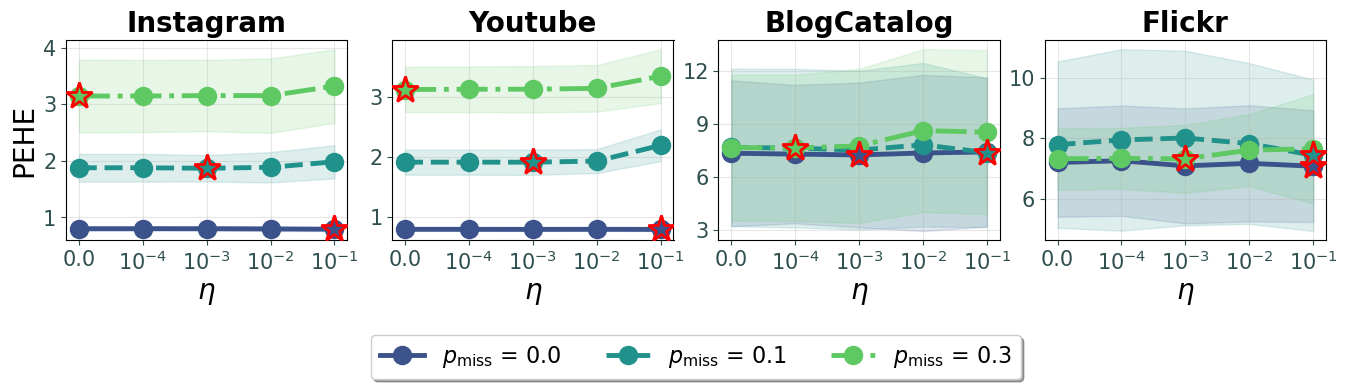

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from line_plots import plot_results
dataset_map = {'Syn_M=None_SimRel=1_Rel=4':"Instagram",  'BlogCatalog1_M=20_SimRel=0_Rel=1':"BlogCatalog", 'BlogCatalog1_M=20_SimRel=1_Rel=4':"BlogCatalog", 'Flickr1_M=20_SimRel=0_Rel=1':"Flickr", 'Flickr1_M=20_SimRel=1_Rel=4':"Flickr", 'Youtube_M=20_SimRel=1_Rel=4':"Youtube"}
    

def process_df(df, method, hyper, metric='SUM'):
    def map_fun(x):
        x = str(x)
        for k, v in dataset_map.items():
            if k in x:
                return v
        return x
    def get_hyper(x):
        x = str(x)
        j = x.index('=')+1
        return x[j:]
    df = df[['method', "Dataset"]+[col for col in df.columns if metric in col]]
    new_column_names = [replace_col(col) for col in df.columns]
    df.columns = new_column_names
    # rows
    df = df[df['method'].str.contains(method, na=False)]
    # process
    df[f"$\\{hyper}$"] = df['method'].apply(lambda x: get_hyper(x))
    
    df['Dataset'] = df['Dataset'].apply(lambda x: map_fun(x))
    df.drop(columns=['method'], inplace=True)
    return df

def replace_col(col):
    for k, v in dataset_map.items():
        if k in col:
            return col.replace(k, v).replace("_MCAR","")
    return col


method='BaLu_GRAPE'
hyper='eta'
metric='PEHE'
train_test_flag= "test"

result_df = None
for p in ['0.0', '0.1', '0.3']:
    _, df = collect_data_p(p, datasets=datasets, result_dir=result_dir, train_test_flag=train_test_flag)
    df = process_df(df, method=method, hyper=hyper, metric=metric)
    df['$p_{\\text{miss}}$'] = [p]*len(df)
    
    if result_df is None:
        result_df = df 
    else:
        result_df = pd.concat([result_df, df], ignore_index=True)

fig, axes = plot_results(result_df, metric=metric, hyper=f"$\\{hyper}$", save_pdf='figs/eta.pdf')
